In [3]:
import time
import scipy
import numpy as np
import pandas as pd
import winsound

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import KFold

from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import tensor
from torch.optim import Adam, NAdam
from torch.optim.lr_scheduler import OneCycleLR as OCR


import torch_geometric
import torch_geometric.transforms as T
from torch_geometric.data import HeteroData
from torch_geometric.nn import HGTConv, SAGEConv, GATConv, Linear, to_hetero, models

from HeteroDataFunctions import *

# print(scipy.__version__)
# print(matplotlib.__version__)
# print(nx.__version__)
print(torch.__version__)

2.0.0+cu118


In [4]:
torch.manual_seed(43)

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce GTX 960
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


# Data Preperations

In [5]:
# Load the complete graph
G = complete_graph(".\\giantmidi-piano\\edgelist")
nx.write_edgelist(G, ".\\giantmidi-piano\\homograph.edgelist", data=False)

loading edgelists...
- notes.edgelist
- program.edgelist
- tempo.edgelist
- time.signature.edgelist
Nodes: 286550
Edges: 2756865


In [6]:
# G = nx.read_edgelist(".\\giantmidi-piano\\homograph.edgelist")

In [7]:
nodes = pd.DataFrame((list(G.nodes)), columns=['name'])
edges = pd.DataFrame(np.array(list(G.edges)), columns=['source', 'target'])

In [8]:
matches = nodes['name'].str.match(r'^-?\d+(\.\d+)?$')

nodes[matches]

name
286548   12

In [9]:
node_categories = node_cat_dict_giant(nodes)
node_categories.keys()

node_cat_dict_giant took 0.56 secs to run


dict_keys(['note_group', 'pitch', 'program', 'MIDI', 'duration', 'velocity', 'time_sig', 'tempo'])

In [10]:
node_categories['note_group']

['g1695254',
 'g1667390',
 'g1692371',
 'g1695258',
 'g51420837',
 'g1689488',
 'g1665463',
 'g1660659',
 'g218473754',
 'g-77676713',
 'g2129513017',
 'g-2070437297',
 'g1715363270',
 'g1634713',
 'g1632789',
 'g-1755257722',
 'g1629911',
 'g1607806',
 'g1605881',
 'g49752537',
 'g1607805',
 'g701174457',
 'g1336994607',
 'g-1123948522',
 'g-1814965607',
 'g1742685976',
 'g1654979489',
 'g1666427',
 'g1849804039',
 'g2138615639',
 'g1662580',
 'g1253873919',
 'g2138615641',
 'g-839965704',
 'g1663542',
 'g1662581',
 'g1660663',
 'g1251110037',
 'g1661620',
 'g1643403095',
 'g1634714',
 'g818847014',
 'g1336999412',
 'g1279743030',
 'g-1258076372',
 'g1337001334',
 'g-1957112255',
 'g-1865510176',
 'g1629907',
 'g-1722810117',
 'g-1206478441',
 'g1607803',
 'g-1973743759',
 'g-898829891',
 'g-2099093357',
 'g-1630582935',
 'g592665512',
 'g-1288887208',
 'g-2013181875',
 'g-1955921654',
 'g209778343',
 'g1605885',
 'g1604921',
 'g50527107',
 'g1292252221',
 'g1079875362',
 'g51540004',

In [11]:
nodes_df_complete = pd.read_csv('.\\giantmidi-piano\\complete_csv\\nodes_complete.csv')
edges_df_complete = pd.read_csv('.\\giantmidi-piano\\complete_csv\\edges_complete.csv')
print('Done')

Done


In [12]:
list(set(edges_df_complete['edge_type']))

['MIDI__has__note_group',
 'MIDI__has__tempo',
 'note_group__has__velocity',
 'MIDI__in__time_sig',
 'MIDI__has__program',
 'note_group__has__duration',
 'note_group__contains__pitch']

In [13]:
node_types = set(nodes_df_complete['node_type'])
node_types

{'MIDI',
 'duration',
 'note_group',
 'pitch',
 'program',
 'tempo',
 'time_sig',
 'velocity'}

In [14]:
edge_types = ["MIDI__has__tempo",
              "MIDI__in__time_sig",
              "MIDI__has__program",
              "MIDI__has__note_group",
              "note_group__has__velocity",
              "note_group__has__duration",
              "note_group__contains__pitch"]

In [15]:
names_list = flatten_lol(node_categories.values())

In [16]:
encoder = Encoder(names_list, n_labels=15)

In [17]:
input_node_dict = {node_type: {'x': encoder.
                    encode_nodes(nodes_df_complete.
                    loc[nodes_df_complete['node_type'] == node_type, ['name']])}
                    for node_type in node_types}

encode_nodes took 0.25 secs to run
encode_nodes took 0.00 secs to run
encode_nodes took 0.00 secs to run
encode_nodes took 0.03 secs to run
encode_nodes took 0.00 secs to run
encode_nodes took 0.00 secs to run
encode_nodes took 10.17 secs to run
encode_nodes took 0.00 secs to run


In [18]:
input_node_dict['note_group']['x']

tensor([[1.5000e+01],
        [1.6000e+01],
        [1.7000e+01],
        ...,
        [2.8565e+05],
        [2.8566e+05],
        [2.8566e+05]])

In [19]:
node_enc_to_idx = {node_type: {encoder.decode_value(node_enc.item()): i for i, node_enc in enumerate(input_node_dict[node_type]['x'])} for node_type in node_types}

In [20]:
input_edge_dict = dict()
for edge_type in edge_types:
    node_type_s, node_type_t = edge_type.split('__')[0], edge_type.split('__')[2]

    edge_df = edges_df_complete.loc[edges_df_complete['edge_type'] == edge_type, ['source', 'target']].copy()

    edge_df['source'], edge_df['target'] = edge_df['source'].map(node_enc_to_idx[node_type_s]), edge_df['target'].map(node_enc_to_idx[node_type_t])

    input_edge_dict[edge_type] = {'edge_index': torch.tensor(edge_df.values).T}


In [21]:
# Extract the label of each Midi.
midi_val = nodes_df_complete.loc[nodes_df_complete['node_type'] == 'MIDI', ['name']].values

In [22]:
def midi_composer(midi_name: str) -> str:
        return midi_name.split('+_')[0].replace('-', "")


In [23]:
midi_classes = [midi_composer(s[0]) for s in midi_val]


In [24]:
lb = LabelEncoder()
y = torch.from_numpy(lb.fit_transform(midi_classes)) # .type(torch.LongTensor)

lb.classes_

array(['Bach', 'Beethoven', 'Carbajo', 'Chopin', 'Czerny', 'Handel',
       'Haydn', 'Liszt', 'Mozart', 'Rebikov', 'Satie', 'Scarlatti',
       'Schubert', 'Scriabin', 'Simpson'], dtype='<U9')

In [25]:
input_node_dict['MIDI']['y'] = y


In [26]:
# H = HeteroData(input_node_dict, **input_edge_dict)
# torch.save(H, '.\\giantmidi-piano\\H.pt')

In [27]:
# H = torch.load('.\\giantmidi-piano\\H.pt')
# print(H)

In [28]:
# To enable 2-way message passing
# H = T.ToUndirected()(H)

In [29]:
# H = T.RandomNodeSplit(num_val=0.1, num_test=0.2)(H)

# Temprorary Functions


In [30]:
def cross_val(dataset, model, folds, epochs, lr, lr_decay_factor, lr_decay_step_size=None, weight_decay=0., exp_factor=.75):
    
    val_losses, accs, durations, models, training_epochs = [], [], [], [], []
    print(f'Transfering dataset to device {device}')
    dataset = dataset.to(device)
    print('Done')
    print('_' * 80)
    print('Starting Cross Validation')
    print('_' * 80)

    scheduler = None

    for fold, (train_idx, test_idx,
               val_idx) in enumerate(zip(*k_fold(dataset, folds))):
        dataset['MIDI'].train_mask = train_idx
        dataset['MIDI'].val_mask = val_idx
        dataset['MIDI'].test_mask = test_idx

        
        # early_stopper = EarlyStopper(patience=patience, min_delta=min_delta, late_start=late_start)


        print(f'Transfering Model to device{device}')
        model = model.to(device)
        
        print('Resetting parameters')
        reset_parameters_(model, dataset)
        

        optimizer = NAdam(model.parameters(), lr=lr, weight_decay=weight_decay)
        loss_fn = F.cross_entropy

        print('Synchronizing GPU')
        if torch.cuda.is_available():
            torch.cuda.synchronize()

        t_start = time.perf_counter()

        print('Starting Training')
        for epoch in range(1, epochs + 1):
            train_loss = train_(model, optimizer, scheduler=scheduler, loss_fn=loss_fn, dataset=dataset, epoch=epoch, epochs=epochs, exp_factor=exp_factor)
            val_losses.append(eval_loss_(model, loss_fn, dataset))
            accs.append(eval_acc_(model, dataset))
            eval_info = {
                'fold': fold,
                'epoch': epoch,
                'train_loss': train_loss,
                'val_loss': val_losses[-1],
                'test_acc': accs[-1],
            }

            print_dict(eval_info)

            
            if lr_decay_factor:
                if epoch  >= (epochs * exp_factor) and epoch % lr_decay_step_size == 0:
                    for param_group in optimizer.param_groups:
                        param_group['lr'] = lr_decay_factor * param_group['lr']

            # if early_stopper.early_stop(val_losses[-1], epoch=epoch):
            #     val_losses = val_losses + [float('inf')] * (epochs - epoch)
            #     accs = accs + [float('NaN')] * (epochs - epoch)
            #     print('Early Stopping at epoch', epoch)
            #     break

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        t_end = time.perf_counter()
        durations.append(t_end - t_start)
        models.append(model)
        training_epochs.append(epoch)

    loss, acc, duration, training_epochs = tensor(val_losses), tensor(accs), tensor(durations), tensor(training_epochs, dtype=torch.float32)
    loss, acc = loss.view(folds, epochs), acc.view(folds, epochs)
    loss, argmin = loss.min(dim=1)
    acc = acc[torch.arange(folds, dtype=torch.long), argmin]

    loss_mean = loss.mean().item()
    acc_mean = acc.mean().item()
    acc_std = acc.std().item()
    duration_mean = duration.mean().item()
    training_epochs_mean = training_epochs.mean().item()
    print(f'Val Loss: {loss_mean:.4f}, Test Accuracy: {acc_mean:.3f} '
          f'± {acc_std:.3f}, Average Duration per fold: {duration_mean/60:.3f} mins')

    return loss_mean, acc_mean, models

def k_fold(dataset, folds):
    skf = KFold(folds, shuffle=True, random_state=42)

    test_indices, train_indices = [], []
    for _, idx in skf.split(torch.zeros(len(dataset['MIDI'].x)), dataset['MIDI'].y):
        test_indices.append(torch.from_numpy(idx).to(torch.long))

    val_indices = [test_indices[i - 1] for i in range(folds)]


    for i in range(folds):
        train_mask = torch.ones(len(dataset['MIDI'].x), dtype=torch.bool)
        train_mask[test_indices[i]] = 0
        train_mask[val_indices[i]] = 0
        train_indices.append(train_mask.nonzero(as_tuple=False).view(-1))

    return train_indices, test_indices, val_indices

def train_(model, optimizer, loss_fn, dataset, epoch, epochs, exp_factor, scheduler=None):
    model.train()
    
    optimizer.zero_grad()
    out = model(dataset.x_dict, dataset.edge_index_dict)

    mask = dataset['MIDI'].train_mask
    loss = loss_fn(out['MIDI'][mask], dataset['MIDI'].y[mask])
    loss.backward()
    optimizer.step()
    if scheduler and epoch <= epochs*exp_factor:
        scheduler.step()
    
    return float(loss)


def eval_acc_(model, dataset):
    model.eval()

    
    mask = dataset['MIDI'].test_mask

    with torch.no_grad():
        pred = model(dataset.x_dict, dataset.edge_index_dict)['MIDI'].argmax(dim=-1)

    y_true = dataset['MIDI'].y[mask].to('cpu').numpy()
    y_pred = pred[mask].to('cpu').numpy()
    
    acc = np.sum(np.equal(y_true, y_pred)) / len(y_true)
    # accs = int((pred[mask] == dataset['MIDI'].y[mask]).sum()) / int(mask.sum())

    return acc


def eval_loss_(model, loss_fn, dataset):
    model.eval()

    
    mask = dataset['MIDI'].val_mask
    with torch.no_grad():
        out = model(dataset.x_dict, dataset.edge_index_dict)
    loss = loss_fn(out['MIDI'][mask], dataset['MIDI'].y[mask])
    return (float(loss))

def reset_parameters_(model, dataset):
    print('Lazy Initialization of Model')
    with torch.no_grad():  # Initialize lazy modules.
        out = model(dataset.x_dict, dataset.edge_index_dict)

    for c in model.children():
        if isinstance(c, torch.nn.ModuleList):
            for d in c:
                for v in d.values():
                    if isinstance(v, SAGEConv):
                        print('Resetting SAGEConv')
                        nn.init.kaiming_normal_(v.lin_l.weight, nonlinearity='relu')
        
    # for c in model.children():
    #     for v in c.values():
    #         if isinstance(v, SAGEConv):
    #             print('Resetting SAGEConv')
    #             nn.init.kaiming_normal_(v.lin_l.weight, nonlinearity='relu')
    #         elif isinstance(c, Linear):
    #             print('Resetting Linear')
    #             nn.init.xavier_normal_(v.weight)
    


def print_dict(d):
    # I want a function that prints the key:values of a dictionary, all in the same line by using a final output string.
    for k, v in d.items():
        print(k, ':', v, end=' | ')
    print('\n' + '-' * 80)



class EarlyStopper:
    def __init__(self, patience=1, min_delta=0, late_start=0):
        self.late_start = late_start
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss, epoch):
        if epoch > self.late_start:
            if validation_loss < self.min_validation_loss:
                self.min_validation_loss = validation_loss
                self.counter = 0
            elif validation_loss > (self.min_validation_loss + self.min_delta):
                self.counter += 1
                if self.counter >= self.patience:
                    return True
        return False


In [31]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, drop_layer: bool=False, drop_rate: float=0.5):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

        self.drop = drop_layer
        self.drop_rate = drop_rate

    def forward(self, x, edge_index):
        
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.drop_rate, training=self.drop)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.drop_rate, training=self.drop)

        return x


# GNN & Training

## 5-Fold CV

In [40]:
# H = torch.load('.\\giantmidi-piano\\H.pt')
H = HeteroData(input_node_dict, **input_edge_dict)
# To enable 2-way message passing
H = T.ToUndirected()(H)

model_cv = models.GraphSAGE(in_channels=-1, hidden_channels=64, num_layers=2, out_channels=len(set(lb.classes_)), dropout=.3)

model_cv = to_hetero(model_cv, H.metadata(), aggr='sum')



In [42]:
loss_mean, acc_mean, models = cross_val(
    dataset=H,
    model=model_cv,
    folds=5,
    epochs=3200,
    lr=0.01,
    weight_decay=0.0005,
    lr_decay_factor=0.5,
    exp_factor=1,
    lr_decay_step_size=50
)

Transfering dataset to device cuda
Done
________________________________________________________________________________
Starting Cross Validation
________________________________________________________________________________
Transfering Model to devicecuda
Resetting parameters
Lazy Initialization of Model
Resetting SAGEConv
Resetting SAGEConv
Resetting SAGEConv
Resetting SAGEConv
Resetting SAGEConv
Resetting SAGEConv
Resetting SAGEConv
Resetting SAGEConv
Resetting SAGEConv
Resetting SAGEConv
Resetting SAGEConv
Resetting SAGEConv
Resetting SAGEConv
Resetting SAGEConv
Resetting SAGEConv
Resetting SAGEConv
Resetting SAGEConv
Resetting SAGEConv
Resetting SAGEConv
Resetting SAGEConv
Resetting SAGEConv
Resetting SAGEConv
Resetting SAGEConv
Resetting SAGEConv
Resetting SAGEConv
Resetting SAGEConv
Resetting SAGEConv
Resetting SAGEConv
Synchronizing GPU
Starting Training
fold : 0 | epoch : 1 | train_loss : 2614821.5 | val_loss : 1444720.875 | test_acc : 0.04666666666666667 | 
---------------

In [33]:
def save_models(models, path):
    for i, model in enumerate(models):
        torch.save(model.state_dict(), f'{path}\\model_{i}.pt')
    print('Models saved at', path)

def load_models(path, folds, model):
    models = []
    print('Loading Models from', path)
    for i in range(folds):
        model.load_state_dict(torch.load(f'{path}\\model_{i}.pt'))
        models.append(model)
    return models

In [37]:
def voting(models, dataset):
    dataset = T.RandomNodeSplit(num_val=0.1, num_test=0.2)(dataset)
    dataset = dataset.to(device)
    mask = dataset['MIDI'].test_mask
    test_predictions = get_predictions(models, dataset, mask)

    # Combine predictions using voting
    stacked_predictions = torch.stack(test_predictions)
    voted_predictions, _ = torch.mode(stacked_predictions, dim=0)

    # Convert to numpy array
    return voted_predictions.to('cpu').numpy(), mask
    

def get_predictions(models, dataset, mask):
    predictions = []
    for model in models:
        model.to(device)
        model.eval()
        with torch.no_grad():
            outputs = model(dataset.x_dict, dataset.edge_index_dict)['MIDI'].argmax(dim=-1)[mask]
            predictions.append(outputs)
    return predictions

In [45]:
save_models(models, '.\\giantmidi-piano\\models\\')

Models saved at .\giantmidi-piano\models\


In [41]:
models_cv = load_models('.\\giantmidi-piano\\models\\', 5, model_cv)

Loading Models from .\giantmidi-piano\models\


In [42]:
predicted, mask = voting(models_cv, H)

predicted


array([ 0,  0,  0,  0,  0,  0,  0,  0,  1,  8,  1,  1,  1,  1,  1,  1,  1,
        8,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  4,  4,  5,  4,  4,  4,  4,  5,  4,  4,  6,  8,
        6,  5,  6,  6,  8,  8,  6,  6,  4,  5,  6,  6,  6,  5,  6,  6,  6,
        6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       11, 13, 10, 12, 12, 11, 10, 13, 10, 10, 11,  8, 11, 11,  9,  8, 13,
       11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 11, 11, 13,
        8, 13, 13, 13, 13, 13,  8, 13, 10, 11, 11, 13, 11, 13],
      dtype=int64)

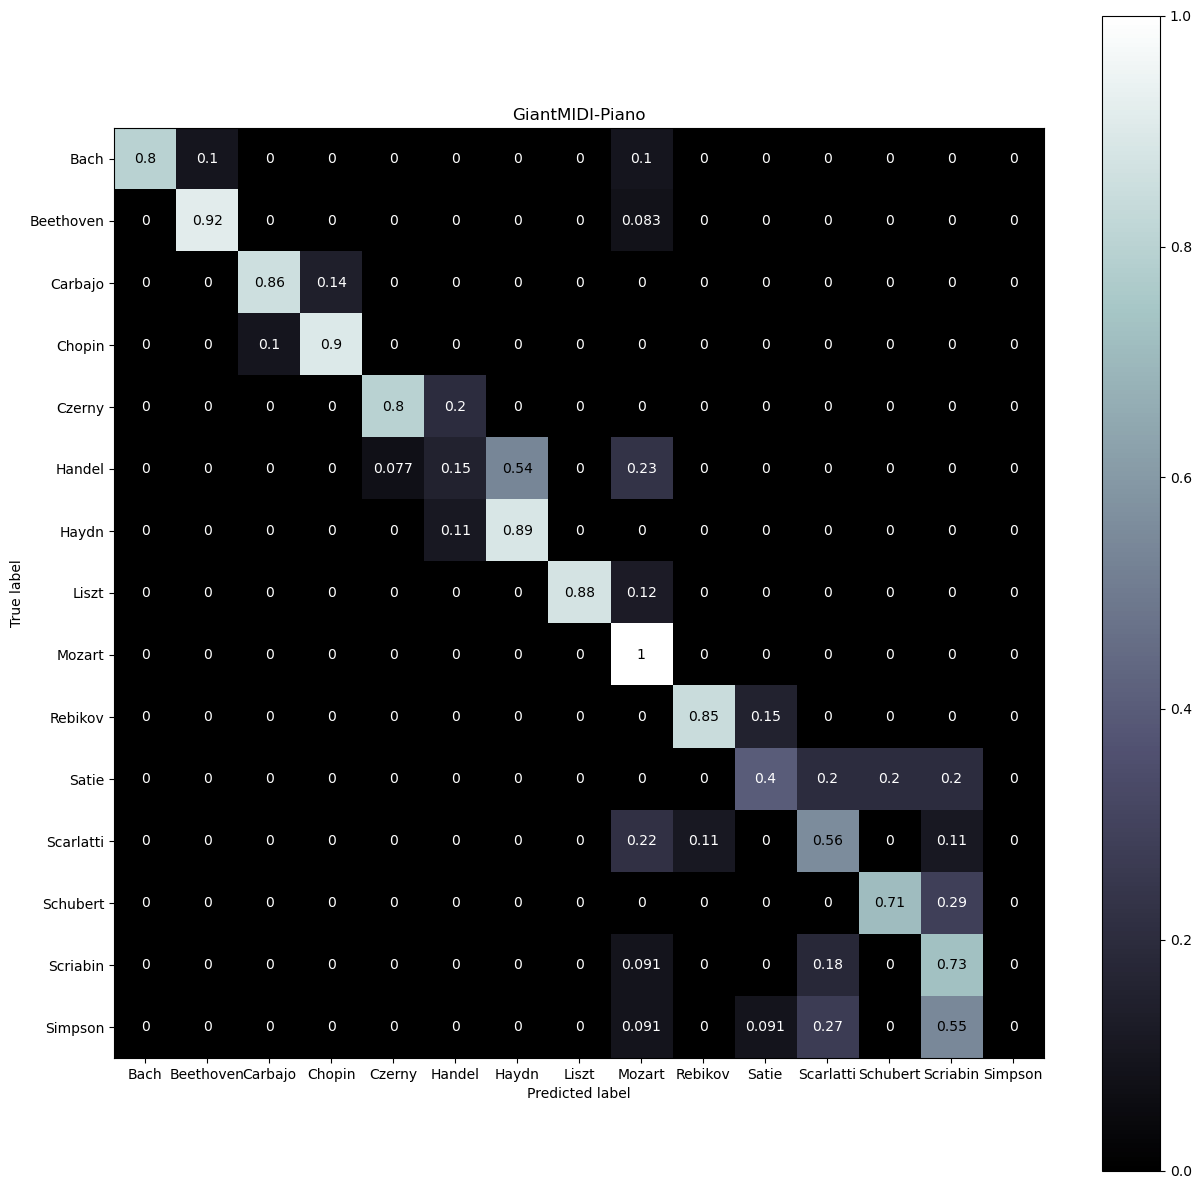

In [44]:
disp = ConfusionMatrixDisplay.from_predictions(y_true=lb.inverse_transform(H['MIDI'].y[mask].to('cpu')), y_pred=lb.inverse_transform(predicted), cmap='bone', normalize='true')

disp.ax_.set_title('GiantMIDI-Piano')
disp.figure_.set_size_inches(15, 15)
plt.show()

In [48]:
import os
os.system('shutdown -s -t 30')

0

## Solo Model

In [30]:
# H = torch.load('.\\giantmidi-piano\\H.pt')
H = HeteroData(input_node_dict, **input_edge_dict).to(device)
# To enable 2-way message passing
H = T.ToUndirected()(H)
H = T.RandomNodeSplit(num_val=0.1, num_test=0.2)(H)
H

HeteroData(
  velocity={ x=[10, 1] },
  duration={ x=[61, 1] },
  note_group={ x=[285642, 1] },
  program={ x=[1, 1] },
  pitch={ x=[84, 1] },
  tempo={ x=[1, 1] },
  MIDI={
    x=[750, 1],
    y=[750],
    train_mask=[750],
    val_mask=[750],
    test_mask=[750]
  },
  time_sig={ x=[1, 1] },
  (MIDI, has, tempo)={ edge_index=[2, 750] },
  (MIDI, in, time_sig)={ edge_index=[2, 750] },
  (MIDI, has, program)={ edge_index=[2, 750] },
  (MIDI, has, note_group)={ edge_index=[2, 953329] },
  (note_group, has, velocity)={ edge_index=[2, 434069] },
  (note_group, has, duration)={ edge_index=[2, 285658] },
  (note_group, contains, pitch)={ edge_index=[2, 1081559] },
  (tempo, rev_has, MIDI)={ edge_index=[2, 750] },
  (time_sig, rev_in, MIDI)={ edge_index=[2, 750] },
  (program, rev_has, MIDI)={ edge_index=[2, 750] },
  (note_group, rev_has, MIDI)={ edge_index=[2, 953329] },
  (velocity, rev_has, note_group)={ edge_index=[2, 434069] },
  (duration, rev_has, note_group)={ edge_index=[2, 285658]

In [31]:
model = models.GraphSAGE(in_channels=-1, hidden_channels=64, num_layers=2, out_channels=len(set(lb.classes_)), dropout=.3)

model = to_hetero(model, H.metadata(), aggr='sum')
model = model.to(device)
model



GraphModule(
  (_trim): ModuleDict(
    (MIDI__has__tempo): TrimToLayer()
    (MIDI__in__time_sig): TrimToLayer()
    (MIDI__has__program): TrimToLayer()
    (MIDI__has__note_group): TrimToLayer()
    (note_group__has__velocity): TrimToLayer()
    (note_group__has__duration): TrimToLayer()
    (note_group__contains__pitch): TrimToLayer()
    (tempo__rev_has__MIDI): TrimToLayer()
    (time_sig__rev_in__MIDI): TrimToLayer()
    (program__rev_has__MIDI): TrimToLayer()
    (note_group__rev_has__MIDI): TrimToLayer()
    (velocity__rev_has__note_group): TrimToLayer()
    (duration__rev_has__note_group): TrimToLayer()
    (pitch__rev_contains__note_group): TrimToLayer()
  )
  (convs): ModuleList(
    (0): ModuleDict(
      (MIDI__has__tempo): SAGEConv(-1, 64, aggr=mean)
      (MIDI__in__time_sig): SAGEConv(-1, 64, aggr=mean)
      (MIDI__has__program): SAGEConv(-1, 64, aggr=mean)
      (MIDI__has__note_group): SAGEConv(-1, 64, aggr=mean)
      (note_group__has__velocity): SAGEConv(-1, 64, agg

In [32]:
optimizer = NAdam(model.parameters(), lr=0.01)

# # reset_parameters_(model, H)
# print('Lazy Initialization of Model')
with torch.no_grad():  # Initialize lazy modules.
    out = model(H.x_dict, H.edge_index_dict)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(H.x_dict, H.edge_index_dict)
    mask = H['MIDI'].train_mask
    loss = F.cross_entropy(out['MIDI'][mask], H['MIDI'].y[mask])
    loss.backward()
    optimizer.step()
    return float(loss)




In [33]:
@torch.no_grad()
def test():
    model.eval()
    pred = model(H.x_dict, H.edge_index_dict)['MIDI'].argmax(dim=-1)

    accs = []

    for mask in [H['MIDI'].train_mask, H['MIDI'].val_mask, H['MIDI'].test_mask]:
        accs.append(int((pred[mask] == H['MIDI'].y[mask]).sum()) / int(mask.sum()))
    return accs


In [34]:
acc_lists = {'train': [], 'val': [], 'test': []}
loss_list = []

for epoch in range(1, 3201):
    loss = train()
    train_acc, val_acc, test_acc = test()

    loss_list.append(loss)

    acc_lists['train'].append(train_acc)
    acc_lists['val'].append(val_acc)
    acc_lists['test'].append(test_acc)

    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc*100:.2f}%, '
          f'Val: {val_acc*100:.2f}%, Test: {test_acc*100:.2f}%')
    

Epoch: 001, Loss: 860415.0625, Train: 5.52%, Val: 5.33%, Test: 7.33%
Epoch: 002, Loss: 754707.0625, Train: 7.62%, Val: 5.33%, Test: 4.67%
Epoch: 003, Loss: 696395.1250, Train: 6.48%, Val: 9.33%, Test: 7.33%
Epoch: 004, Loss: 765509.1250, Train: 7.62%, Val: 2.67%, Test: 4.00%
Epoch: 005, Loss: 698652.1250, Train: 5.52%, Val: 6.67%, Test: 4.67%
Epoch: 006, Loss: 745868.1250, Train: 6.48%, Val: 5.33%, Test: 6.67%
Epoch: 007, Loss: 858863.5625, Train: 6.48%, Val: 10.67%, Test: 8.67%
Epoch: 008, Loss: 860548.1250, Train: 7.81%, Val: 5.33%, Test: 4.67%
Epoch: 009, Loss: 723491.2500, Train: 8.00%, Val: 10.67%, Test: 6.00%
Epoch: 010, Loss: 437863.5625, Train: 7.24%, Val: 5.33%, Test: 8.00%
Epoch: 011, Loss: 544159.7500, Train: 6.86%, Val: 8.00%, Test: 10.67%
Epoch: 012, Loss: 455458.5625, Train: 8.19%, Val: 12.00%, Test: 10.67%
Epoch: 013, Loss: 383103.3750, Train: 7.81%, Val: 5.33%, Test: 8.67%
Epoch: 014, Loss: 469077.2188, Train: 8.38%, Val: 20.00%, Test: 9.33%
Epoch: 015, Loss: 512620.562

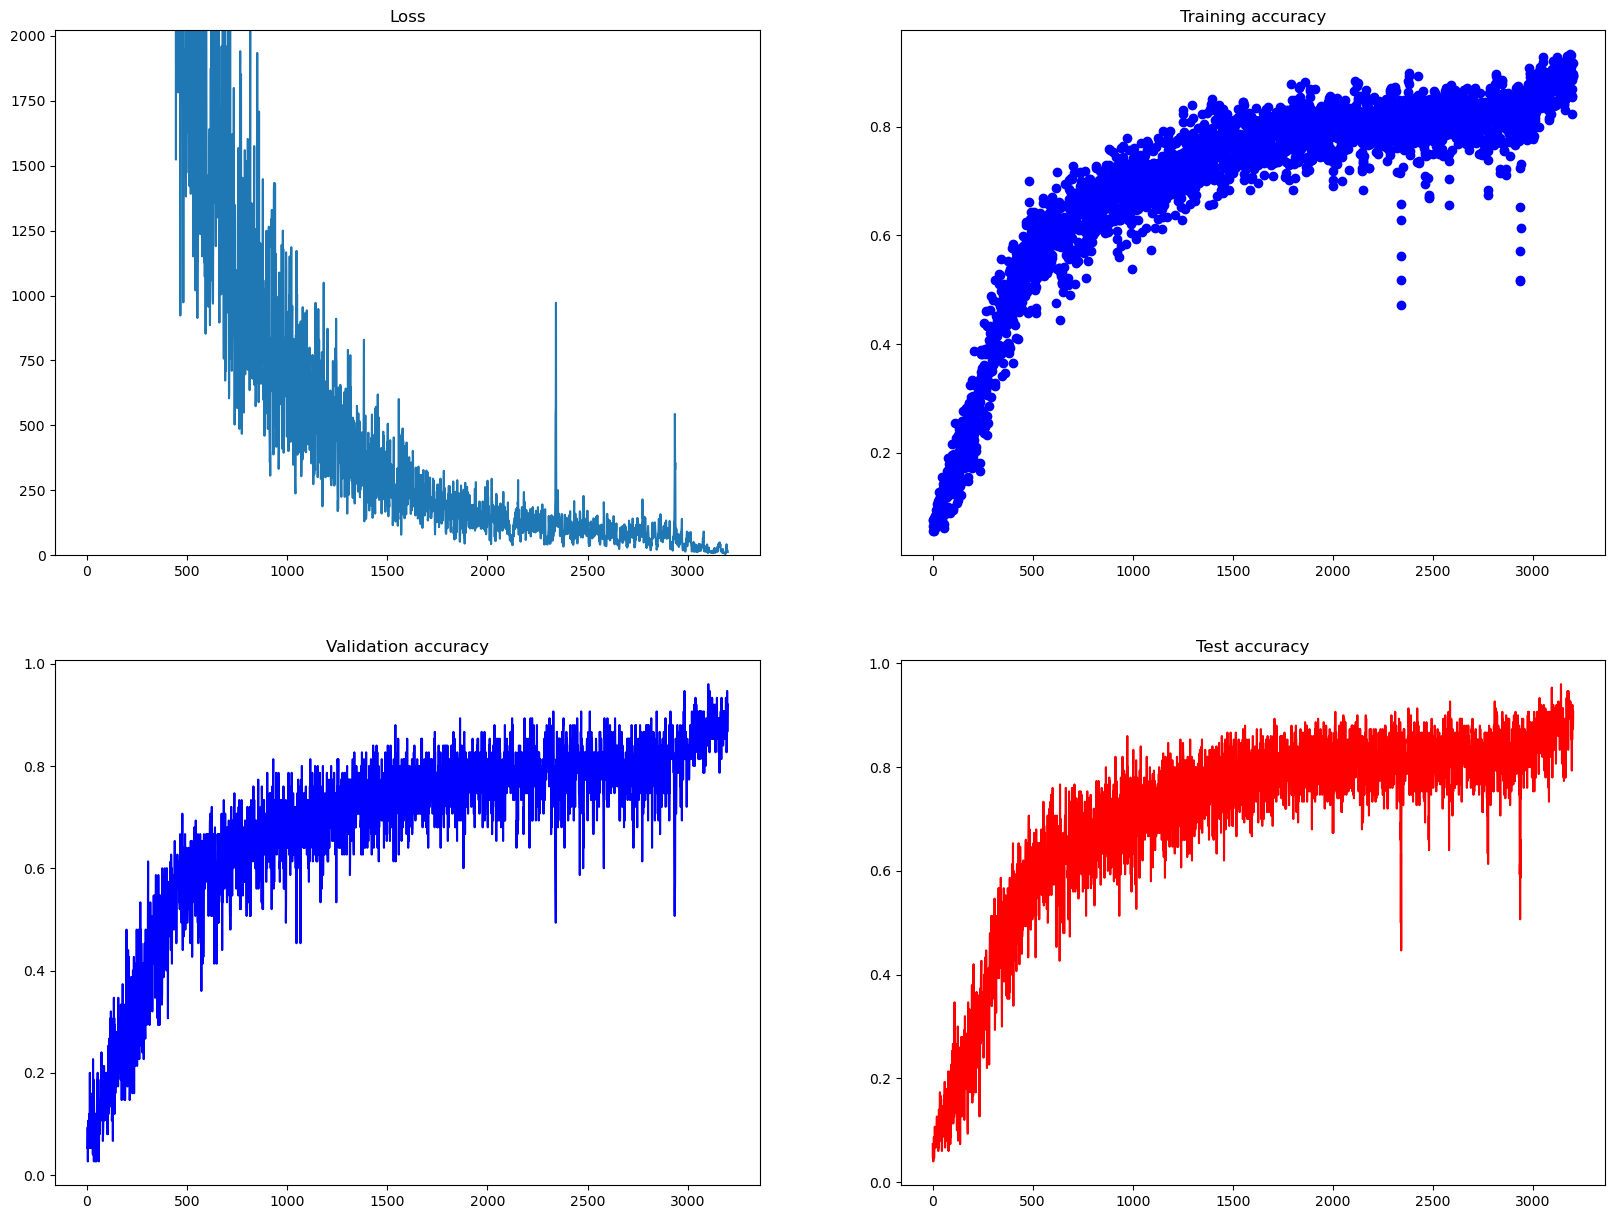

In [35]:
plot_4graphs(loss_list, acc_lists, 800)

In [36]:
mask = H['MIDI'].test_mask

predicted = model(H.x_dict, H.edge_index_dict)['MIDI'].argmax(dim=-1)[mask]

predicted

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,
         5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 12, 12, 12, 12, 11, 12, 12, 12, 12, 12, 12, 12, 12, 13,
        13, 13, 13, 11, 13, 13, 13, 13, 13, 14, 14, 14, 13, 13, 13, 14, 14, 14,
        14, 14, 14, 14, 14, 13], device='cuda:0')

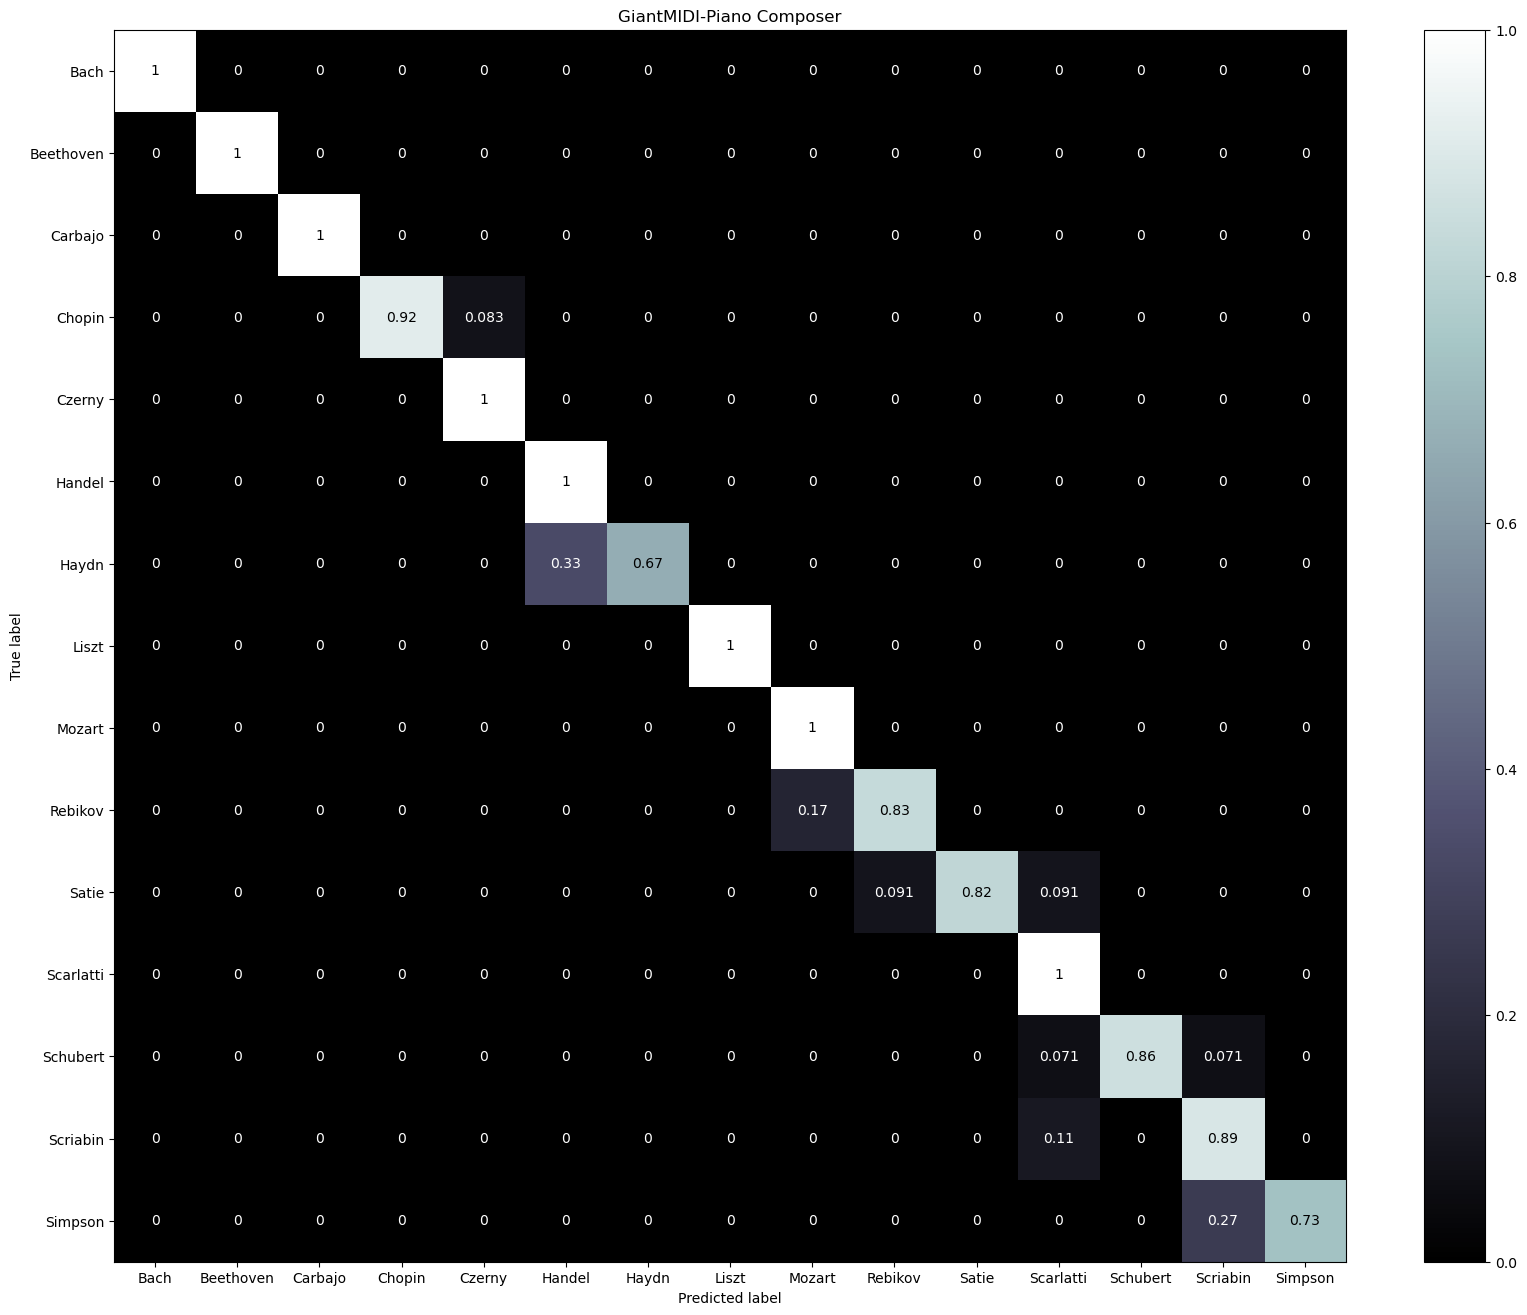

In [37]:

disp = ConfusionMatrixDisplay.from_predictions(y_true=lb.inverse_transform(H['MIDI'].y[mask].to('cpu')), y_pred=lb.inverse_transform(predicted.to('cpu')), cmap='bone', normalize='true')

disp.figure_.set_size_inches(20, 16)
disp.ax_.set_title('GiantMIDI-Piano Composer')

disp.figure_.savefig(".\giantmidi-piano\giantmidi_conf_matrix1.png")
plt.show()

In [38]:
path = '.\\giantmidi-piano'
torch.save(model.state_dict(), f'{path}\\model_solo.pt')
print('Model saved at', path)

Model saved at .\giantmidi-piano


# Old Training

In [ ]:
optimizer_name = "Adam"
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(H.x_dict, H.edge_index_dict)
    mask = H['MIDI'].train_mask
    loss = F.cross_entropy(out['MIDI'][mask], H['MIDI'].y[mask])
    loss.backward()
    optimizer.step()
    return float(loss)

In [ ]:
@torch.no_grad()
def test():
    model.eval()
    pred = model(H.x_dict, H.edge_index_dict)['MIDI'].argmax(dim=-1)

    accs = []

    for mask in [H['MIDI'].train_mask, H['MIDI'].val_mask, H['MIDI'].test_mask]:
        accs.append(int((pred[mask] == H['MIDI'].y[mask]).sum()) / int(mask.sum()))
    return accs

In [ ]:
acc_lists = {'train': [], 'val': [], 'test': []}
loss_list = []

for epoch in range(1, 3201):
    loss = train()
    train_acc, val_acc, test_acc = test()

    loss_list.append(loss)

    acc_lists['train'].append(train_acc)
    acc_lists['val'].append(val_acc)
    acc_lists['test'].append(test_acc)

    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
          f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 001, Loss: 965644.8750, Train: 0.0419, Val: 0.0000, Test: 0.0267
Epoch: 002, Loss: 558703.0625, Train: 0.0667, Val: 0.0133, Test: 0.0133
Epoch: 003, Loss: 568435.5625, Train: 0.0667, Val: 0.0667, Test: 0.0667
Epoch: 004, Loss: 754243.2500, Train: 0.0514, Val: 0.0533, Test: 0.0400
Epoch: 005, Loss: 997509.9375, Train: 0.0629, Val: 0.0533, Test: 0.0867
Epoch: 006, Loss: 1405596.5000, Train: 0.0629, Val: 0.0267, Test: 0.0800
Epoch: 007, Loss: 1795945.7500, Train: 0.0952, Val: 0.1733, Test: 0.0733
Epoch: 008, Loss: 2163027.0000, Train: 0.0667, Val: 0.0267, Test: 0.0867
Epoch: 009, Loss: 2465640.2500, Train: 0.0838, Val: 0.1200, Test: 0.1200
Epoch: 010, Loss: 2559085.5000, Train: 0.0629, Val: 0.1067, Test: 0.0600
Epoch: 011, Loss: 2518800.2500, Train: 0.0629, Val: 0.1067, Test: 0.0600
Epoch: 012, Loss: 2119326.2500, Train: 0.0629, Val: 0.1067, Test: 0.1000
Epoch: 013, Loss: 1700765.2500, Train: 0.0762, Val: 0.0267, Test: 0.0533
Epoch: 014, Loss: 1849242.2500, Train: 0.0762, Val: 0.02

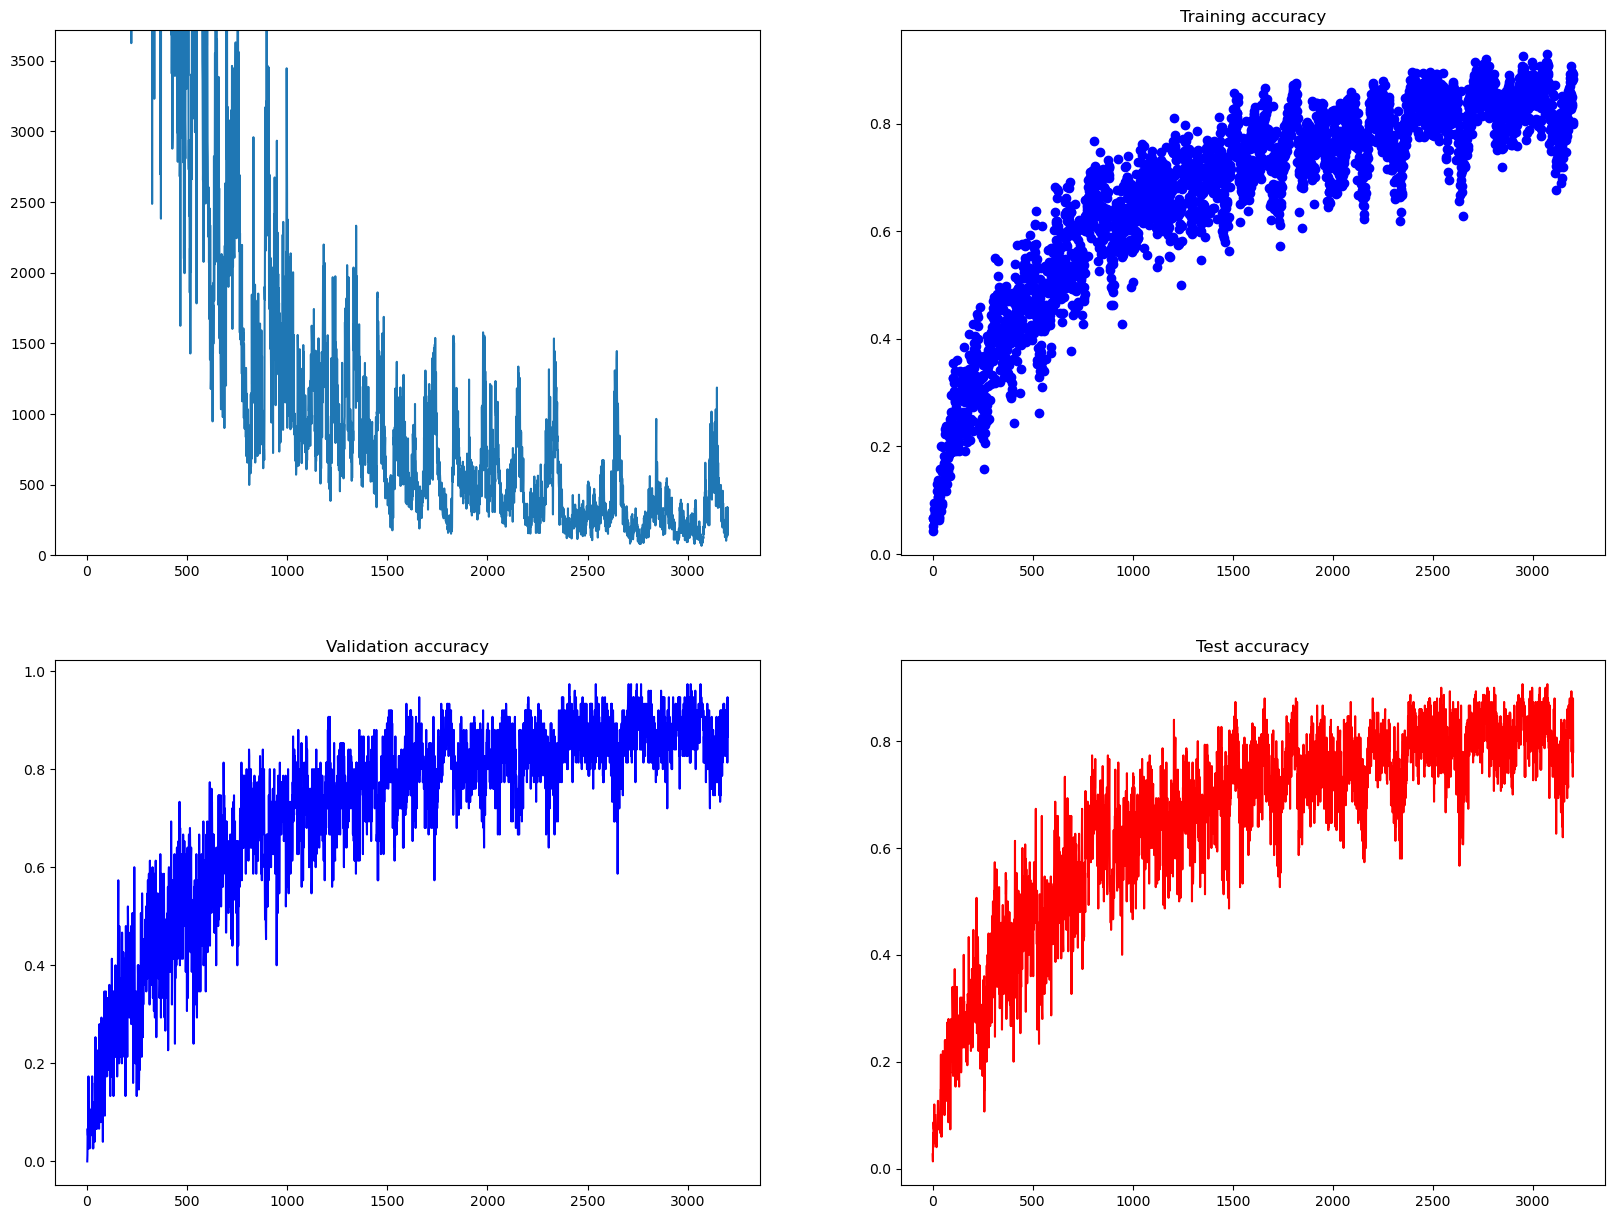

In [ ]:
plot_4graphs(loss_list, acc_lists, 800)

In [ ]:
mask = H['MIDI'].test_mask

predicted = model(H.x_dict, H.edge_index_dict)['MIDI'].argmax(dim=-1)[mask]

predicted

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  1,
         1,  1,  0,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  6,  5,  5,
         6,  6,  5,  6,  6,  6,  6,  6,  6,  6,  0,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  8,  7,  8,  8,  8,  8,  8,
         9,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 11, 10,
        11, 10, 10, 10,  9, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12,
        12, 12, 12, 12, 12, 12, 13, 12, 12, 14, 13, 13, 11, 13, 14, 14, 14, 13,
        13, 14, 14, 14, 11, 14], device='cuda:0')

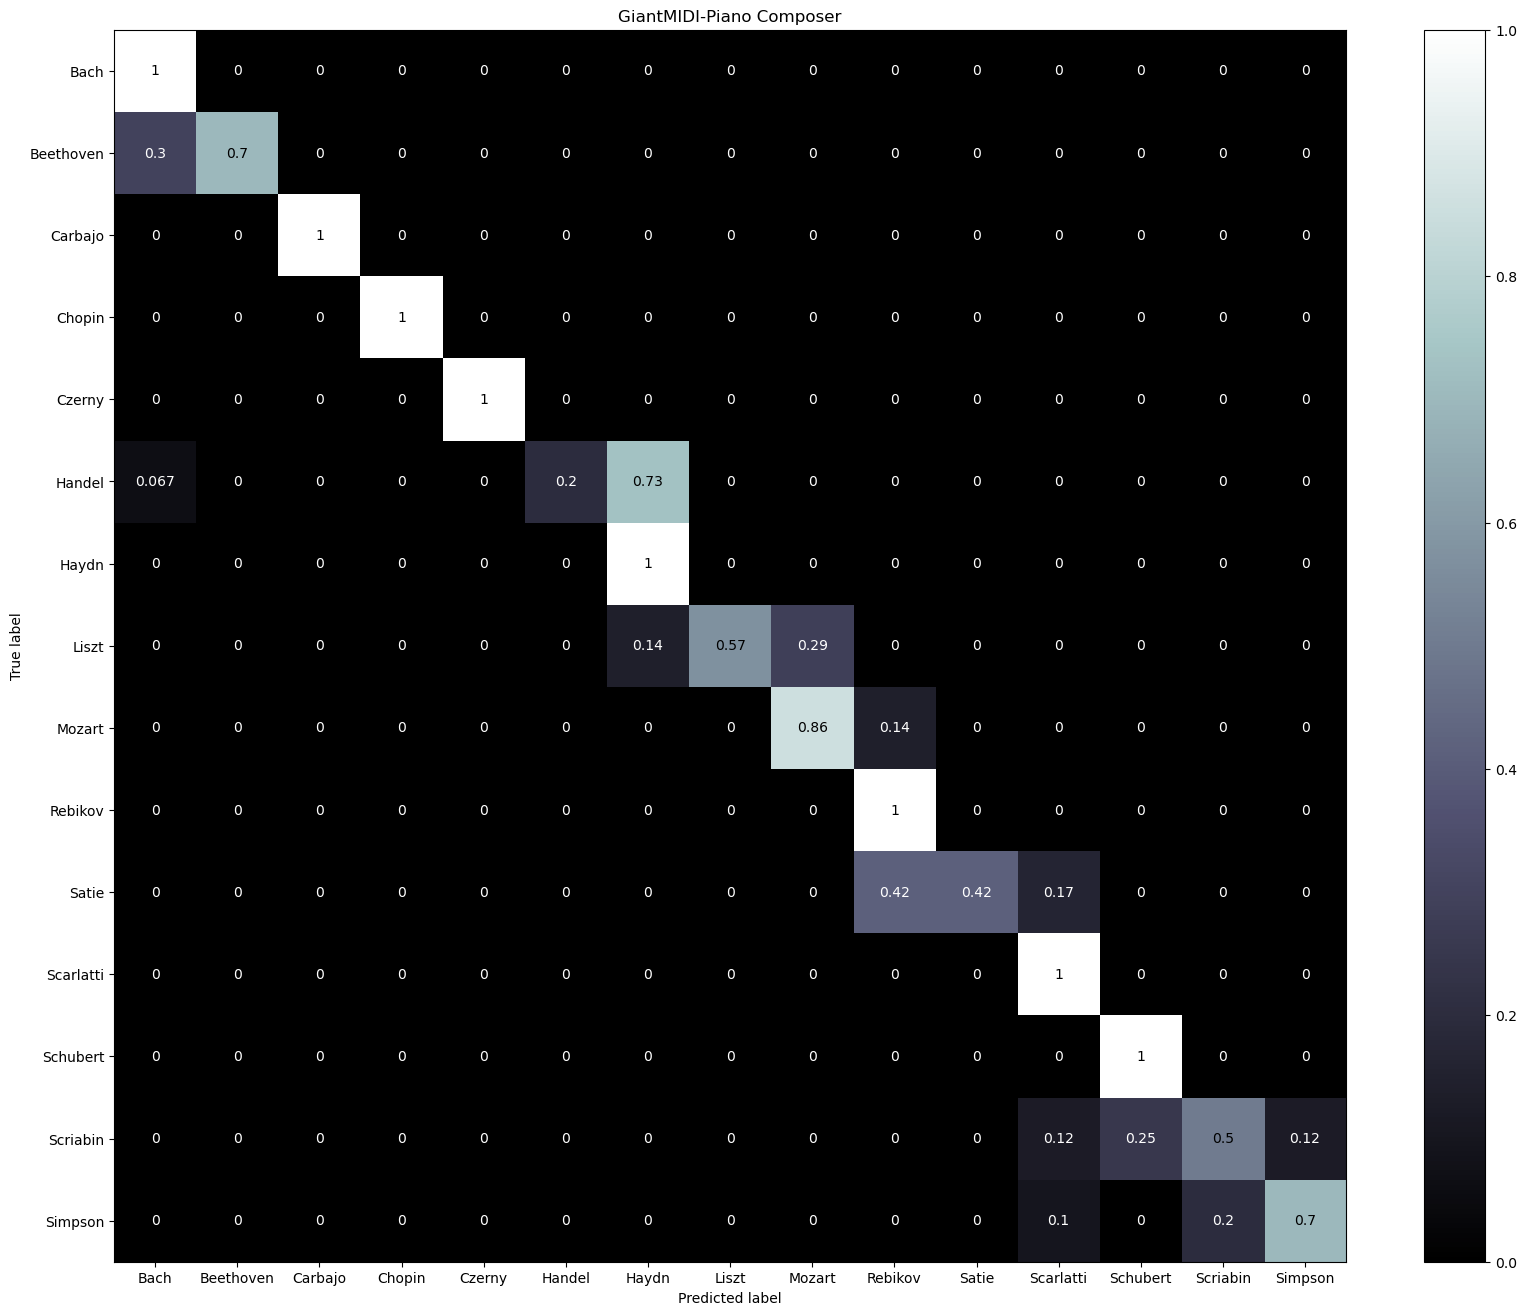

In [ ]:

disp = ConfusionMatrixDisplay.from_predictions(y_true=lb.inverse_transform(H['MIDI'].y[mask].to('cpu')), y_pred=lb.inverse_transform(predicted.to('cpu')), cmap='bone', normalize='true')

disp.figure_.set_size_inches(20, 16)
disp.ax_.set_title('GiantMIDI-Piano Composer')

disp.figure_.savefig(".\giantmidi-piano\giantmidi_conf_matrix1.png")
plt.show()

In [ ]:
winsound.Beep(400, 700)